In [1]:
#!curl https://www.ssa.gov/oact/babynames/names.zip -o names.zip

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from zipfile import ZipFile
import os
import re

In [2]:
%matplotlib inline
sns.set(style='darkgrid')
c = ['steelblue','cyan','red','magenta','yellow','mediumseagreen','bisque','crimson','pink','mediumvioletred']

In [4]:
zip = ZipFile('names.zip')
files = zip.namelist()
names = []
for file in files:
    if '.txt' in file:
        year = re.findall(r'[0-9]{4}',file)
        df = pd.read_csv(zip.open(file),names=['Name','Gender','Count'])
        df['Year'] = int(*year)
        names.append(df)
names = pd.concat(names,ignore_index=True)
indexed_names=names.set_index(['Gender','Name','Year']).sort_index()

In [5]:
def plotnames(gender,name):
    result = indexed_names.loc[gender,name]
    plt.plot(result.index,result.values)
    
def topten(gender,year):
    #top_ten = names[(names['Year'] == year) & (names['Gender'] == gender)].sort_values('Count',ascending=False).head(10).reset_index()
    top_ten = indexed_names.loc[gender,:,year].sort_values('Count',ascending=False).reset_index().head(10)
    top_ten.drop(['Year','Gender','Count'],axis=1,inplace=True)
    top_ten.columns = [year]
    top_ten.index = top_ten.index+1
    return top_ten

def toptens(gender,year0,year1):
    years = [topten(gender,year) for year in range(year0,year1+1)]
    return years[0].join(years[1:])

def pct_change(year0,year1,asc=False):
    namesyear0= indexed_names.loc[['M','F'],:,year0].groupby(['Gender','Name']).sum().reset_index()
    namesyear0 = namesyear0[namesyear0['Count']>=1000]
    namesyear0[year0] = namesyear0['Count']
    namesyear0.drop(['Count'],inplace=True,axis=1)
    namesyear1 = indexed_names.loc[['M','F'],:,year1].groupby(['Gender','Name']).sum().reset_index()
    namesyear1 = namesyear1[namesyear1['Count']>=1000]
    namesyear1[year1] = namesyear1['Count']
    namesyear1.drop(['Count'],inplace=True,axis=1)
    result_df = pd.merge(namesyear0,namesyear1,on=['Gender','Name'])
    result_df = result_df.set_index(['Gender','Name']).sort_index()
    result_df['Pct_Change'] = result_df.pct_change(axis='columns')[year1]
    result_df = result_df.sort_values('Pct_Change',ascending=asc).head(10)
    result_df['Pct_Change'] = pd.Series(["{0:.2f}%".format(x*100) for x in result_df['Pct_Change']],index=result_df.index)
    result_df = result_df.reset_index()
    result_df.index = result_df.index+1
    return result_df

In [6]:
toptens('M',2007,2017)

,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
1,Jacob,Jacob,Jacob,Jacob,Jacob,Jacob,Noah,Noah,Noah,Noah,Liam
2,Michael,Michael,Ethan,Ethan,Mason,Mason,Jacob,Liam,Liam,Liam,Noah
3,Ethan,Ethan,Michael,Michael,William,Ethan,Liam,Mason,Mason,William,William
4,Joshua,Joshua,Alexander,Jayden,Jayden,Noah,Mason,Jacob,Jacob,Mason,James
5,Daniel,Daniel,William,William,Noah,William,William,William,William,James,Logan
6,Christopher,Alexander,Joshua,Alexander,Michael,Liam,Ethan,Ethan,Ethan,Benjamin,Benjamin
7,Anthony,Anthony,Daniel,Noah,Ethan,Michael,Michael,Michael,James,Jacob,Mason
8,William,William,Jayden,Daniel,Alexander,Jayden,Alexander,Alexander,Alexander,Michael,Elijah
9,Matthew,Christopher,Noah,Aiden,Aiden,Alexander,Jayden,James,Michael,Elijah,Oliver
10,Andrew,Matthew,Christopher,Anthony,Daniel,Aiden,Daniel,Daniel,Benjamin,Ethan,Jacob


Text(0.5, 1.0, 'Total number of babies born per year.')

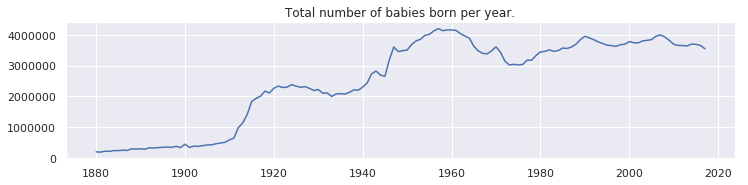

In [7]:
plt.figure(figsize=(12,2.5))
total_babies_born_per_year = names.groupby('Year').sum()
plt.plot(total_babies_born_per_year.index,total_babies_born_per_year.values)
plt.title('Total number of babies born per year.')

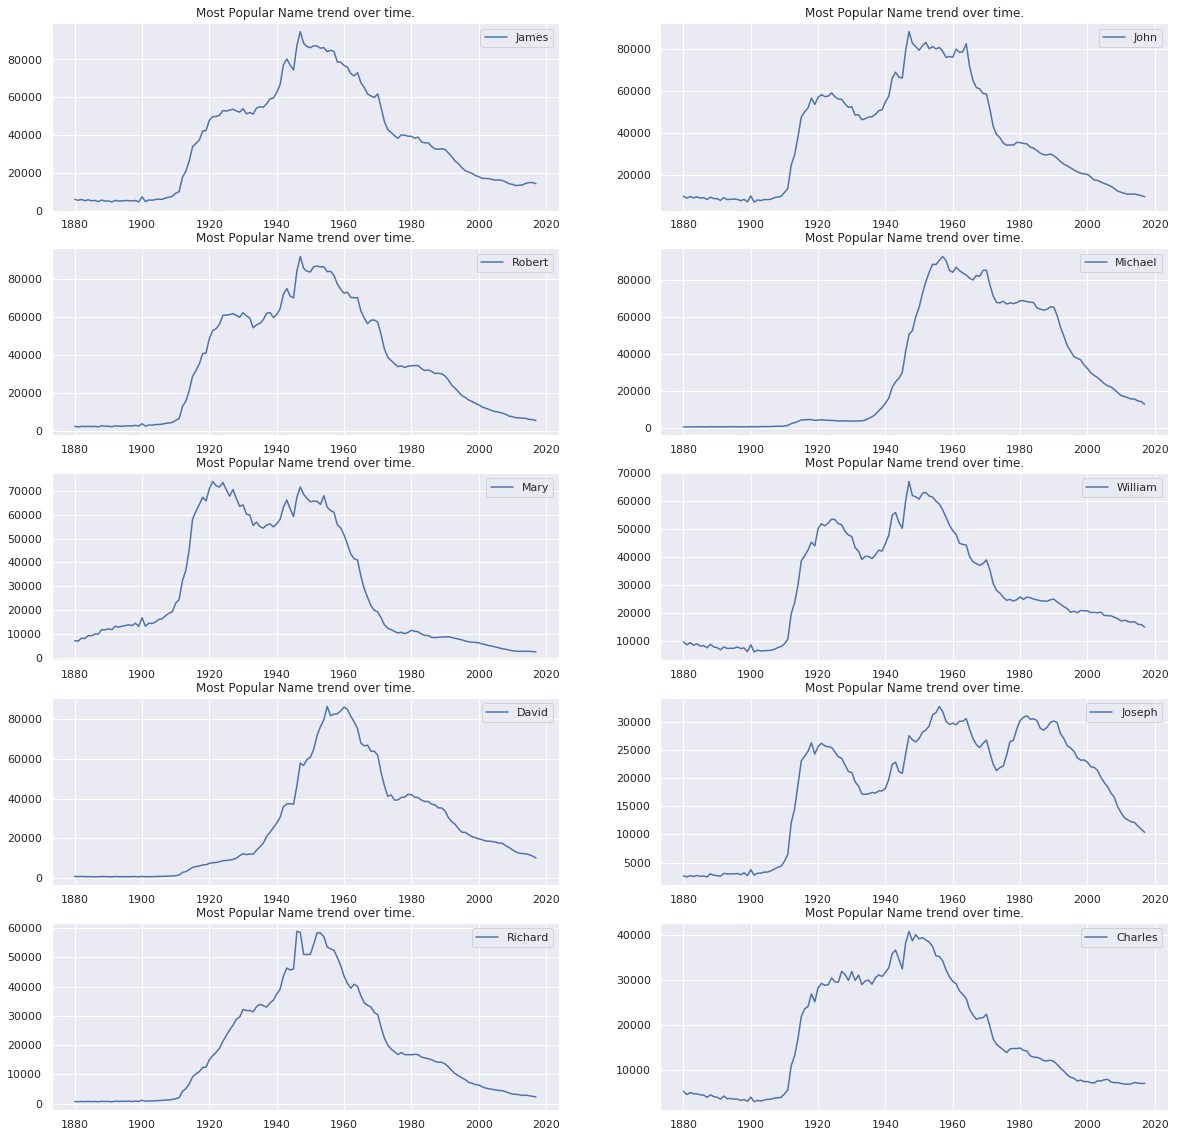

In [8]:
plt.figure(figsize=(20,20))

record_10 = names.groupby(['Name','Gender']).sum().sort_values('Count',ascending=False).reset_index().head(10)
record_10.drop(['Count','Year'],axis=1,inplace=True)

for i,record in record_10.iterrows():
    plt.subplot(5,2,i+1)
    plotnames(record[1],record[0])
    plt.legend(record)
    plt.title("Most Popular Name trend over time.")

In [9]:
print("There are " + str(len(names['Name'].unique()))+ " unique names out of " + str(sum(names['Count'])) + " babies born.")

There are 97310 unique names out of 348120517 babies born.


Text(0.5, 1.0, 'Top 10 names that no longer exist.')

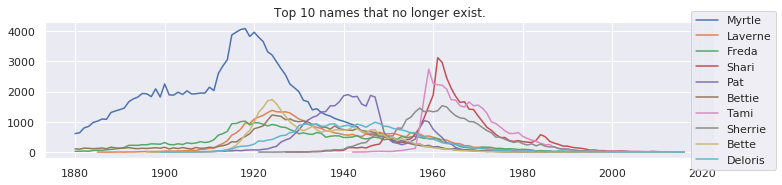

In [10]:
plt.figure(figsize=(12,2.5))
names_2017 = set(indexed_names.loc[['F','M'],:,2017].reset_index()['Name'])
all_names = set(names['Name'].unique())
not_in_2017 = pd.DataFrame(list(all_names-names_2017),columns=['Name'])
not_in_2017 = pd.merge(not_in_2017,names,how='left',on='Name').groupby(['Name','Gender']).sum().sort_values('Count',ascending=False).reset_index().head(10)
not_in_2017.drop(['Count','Year'],inplace=True,axis=1)

for i,record in not_in_2017.iterrows():
    plotnames(record[1],record[0])

plt.legend(not_in_2017['Name'],bbox_to_anchor=(1.1,.5),loc='right')
plt.title('Top 10 names that no longer exist.')

Text(0.5, 1.0, 'Top New Names in 2017')

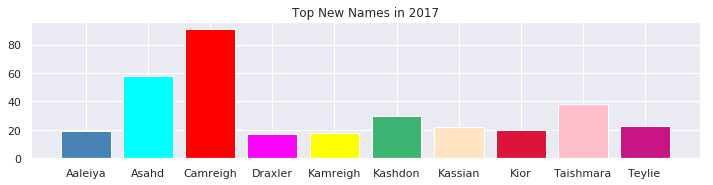

In [11]:
plt.figure(figsize=(12,2.5))
names_less_2017 = set(indexed_names.loc[['F','M'],:,:2017-1].reset_index()['Name'])
new_names = pd.DataFrame(list(names_2017-names_less_2017),columns=['Name'])
new_names = pd.merge(new_names,names,how='left',on='Name').groupby(['Name','Gender']).sum().sort_values('Count',ascending=False).reset_index().head(10)
new_names.drop(['Year'],inplace=True,axis=1)
new_names.sort_values('Name',ascending=True,inplace=True)
plt.bar(new_names['Name'],new_names['Count'],color=c)
plt.title('Top New Names in 2017')

   Gender       Name  2000   2017 Pct_Change
1       F  Charlotte  1104  12893   1067.84%
2       F        Ava  1796  15902    785.41%
3       F     Amelia  1531  11800    670.74%
4       M       Liam  2780  18728    573.67%
5       F       Ella  1220   8014    556.89%
6       M     Jayden  1821   9495    421.42%
7       F     Evelyn  2222  10675    380.42%
8       M        Eli  1464   6553    347.61%
9       F      Avery  1832   8186    346.83%
10      F     Aubrey  1409   5891    318.10%


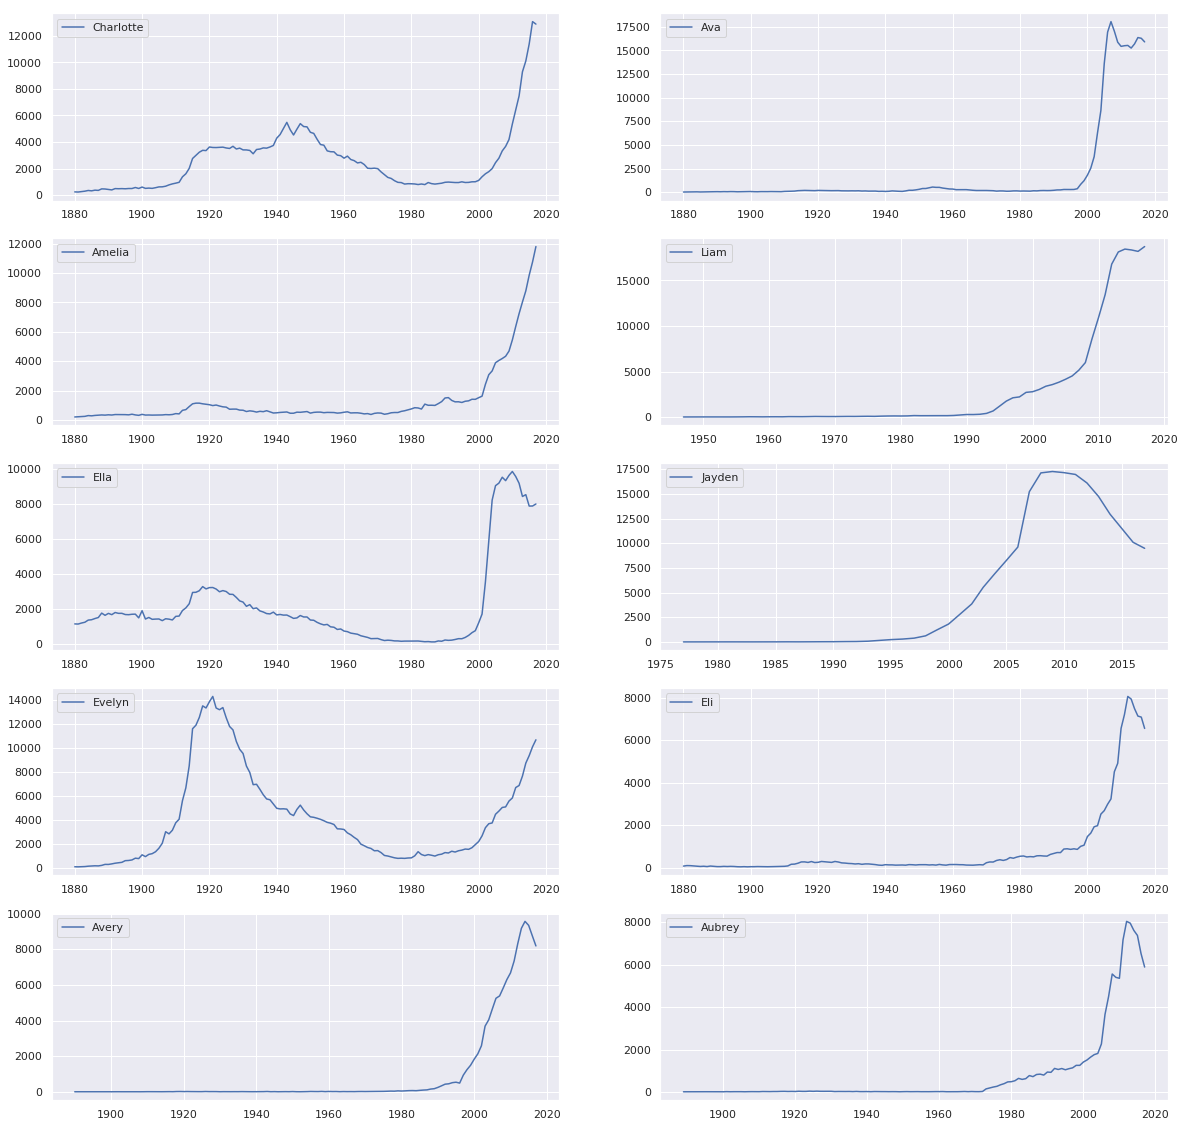

In [12]:
plt.figure(figsize=(20,20))
result_df = pct_change(2000,2017,False)
print(result_df)
for i,record in result_df.iterrows():
    plt.subplot(5,2,i)
    plotnames(record['Gender'],record['Name'])
    plt.legend([record['Name']],loc="upper left")

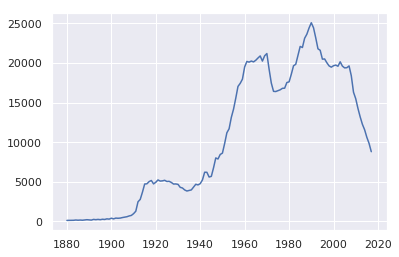

In [14]:
plotnames('M','Anthony')

In [13]:
names

,Name,Gender,Count,Year
0,Mary,F,7065,1880
1,Anna,F,2604,1880
2,Emma,F,2003,1880
3,Elizabeth,F,1939,1880
4,Minnie,F,1746,1880
5,Margaret,F,1578,1880
6,Ida,F,1472,1880
7,Alice,F,1414,1880
8,Bertha,F,1320,1880
9,Sarah,F,1288,1880
